In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<Figure size 432x288 with 0 Axes>

## Custom functions definition:

In [3]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [4]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [5]:
df = df_test.sample(frac=0.8,random_state=42)
df_test = df_test.sample(frac=0.8, random_state=42)

NOTE: UTF-8 encoding does not work on the dataset when loading it with pandas 'read_csv' function. This lead to the use of 'ISO-8859-1'/latin-1 encoding. <br>
It will be found later that some special characters like apostrophes are turned into '\x92', which will be taken care of during the data cleaning process.
                                                                                                         

In [6]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1070,1071,46023,NaN,13-03-2020,At my local grocery store in New Hampshire... ...,Neutral
354,355,45307,NaN,12-03-2020,"Seeing resellers sell masks, alcohols and othe...",Extremely Negative
881,882,45834,NaN,12-03-2020,"Where did coronavirus come from, and where wil...",Extremely Negative
196,197,45149,"Roma, Lazio",11-03-2020,"If you still can, stock up on dry and canned f...",Neutral
3518,3519,48471,NaN,16-03-2020,Popped over at my local supermarket n it s zom...,Negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3038 entries, 1070 to 894
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3038 non-null   int64 
 1   ScreenName     3038 non-null   int64 
 2   Location       2375 non-null   object
 3   TweetAt        3038 non-null   object
 4   OriginalTweet  3038 non-null   object
 5   Sentiment      3038 non-null   object
dtypes: int64(2), object(4)
memory usage: 166.1+ KB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

In [8]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

## Duplicate tweets?

In [9]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3038 entries, 1070 to 894
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       3038 non-null   int64         
 1   ScreenName     3038 non-null   int64         
 2   Location       2375 non-null   object        
 3   TweetAt        3038 non-null   datetime64[ns]
 4   OriginalTweet  3038 non-null   object        
 5   Sentiment      3038 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 166.1+ KB


Good news, No duplicate tweets !

# Tweets count by date

In [11]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

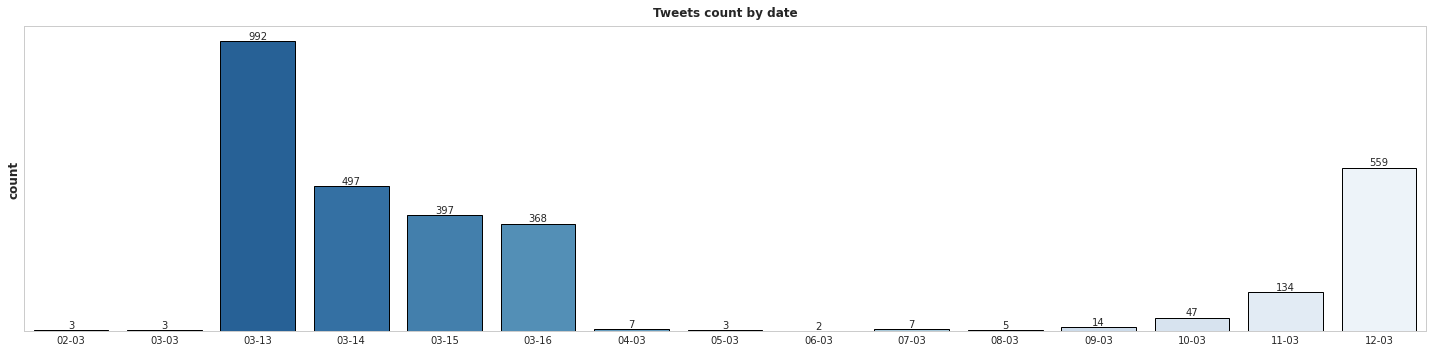

In [12]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.

# Tweets per country and city

In [13]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [14]:
# plt.figure(figsize=(15,6))
# ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
# plt.title('Tweets count by country')
# plt.xticks(rotation=70)
# plt.yticks([])
# ax.bar_label(ax.containers[0])
# plt.ylabel('count')
# plt.xlabel('')
# plt.show()

The 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

# Tweets Deep Cleaning

In the following, we will perform some data cleaning on the raw text of the tweets.<br>
To simplify the analaysis, we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [15]:
df = df[['OriginalTweet','Sentiment']]

In [16]:
df_test = df_test[['OriginalTweet','Sentiment']]

**Then we define custom functions to clean the text of the tweets.**

In [17]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [18]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [19]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [20]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [21]:
df['text_clean'].head()

1070    at my local grocery store in new hampshire cor...
354     seeing resellers sell masks alcohols and other...
881     where did coronavirus come from and where will...
196     if you still can stock up on dry and canned fo...
3518    popped over at my local supermarket n it s zom...
Name: text_clean, dtype: object

In [22]:
df_test['text_clean'].head()

1070    at my local grocery store in new hampshire cor...
354     seeing resellers sell masks alcohols and other...
881     where did coronavirus come from and where will...
196     if you still can stock up on dry and canned fo...
3518    popped over at my local supermarket n it s zom...
Name: text_clean, dtype: object

In [23]:
df['text_clean'][1:8].values

array(['seeing resellers sell masks alcohols and other necessities in prices which are 515x more expensive compared to srps makes me wonder how can people be so heartless insensitive and opportunistic in these times of crisis covid2019',
       'where did coronavirus come from and where will it take us an interview with rob wallace author of big farms make big flu',
       'if you still can stock up on dry and canned food and bottled water or a water purifier coronavirus',
       'popped over at my local supermarket n it s zombie land not sure why people are panicking are people stacking up for few weeks or year smh hardly any milk frozen food tins meds pasta all gone in effect stock n crypto market crashing interest rates to zero',
       'one wonders are our grocery store shelves empty because of coronavirus zombies stripping them or because the indigenous rail blockages',
       'itv vera opening scene a supermarket full of goodshow long before we see that again covid19',
       'he

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [24]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [25]:
df['text_len'] = text_len

In [26]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [27]:
df_test['text_len'] = text_len_test

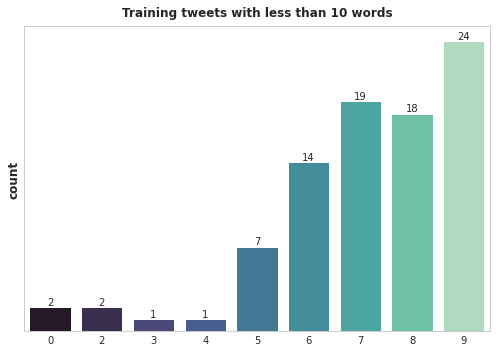

In [28]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

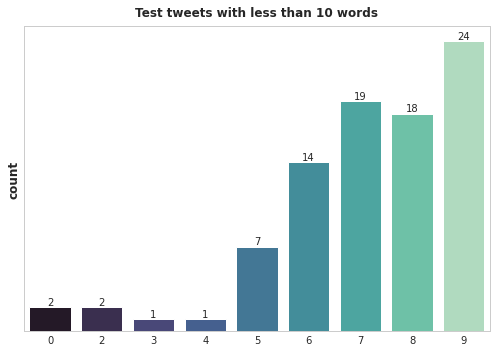

In [29]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [30]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (3038, 4)
 DF TEST SHAPE: (3038, 4)


In [31]:
df = df[df['text_len'] > 4]

In [32]:
df_test = df_test[df_test['text_len'] > 4]

In [33]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (3032, 4)
 DF TEST SHAPE: (3032, 4)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [34]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [36]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


Let's check the long tokenized sentences (with more than 80 tokens ):

In [37]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1812, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 1853, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias
INDEX: 2571, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety


These sentences are not in english. They should be dropped.

In [38]:
df['token_lens'] = token_lens

In [39]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,69
2420,Covid-19 is causing an extreme amount of panic...,Extremely Negative,covid19 is causing an extreme amount of panic ...,54,69


In [40]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
159,To all the people in the UK who are stock pili...,Extremely Negative,to all the people in the uk who are stock pili...,55,67
3560,What's the craziest thing you've done in the l...,Negative,whats the craziest thing youve done in the las...,44,67
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,67
300,Dont let be lumped in with Toliet paper users...,Neutral,dont let be lumped in with toliet paper users ...,30,67
819,"All these years, ppl looked at me like a freak...",Positive,all these years ppl looked at me like a freak ...,45,67


The dataset looks more clean now. We will shuffle it and reset the index.

In [41]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [42]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [43]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [44]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1812, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 1853, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias
INDEX: 2571, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety


In [45]:
df_test['token_lens'] = token_lens_test

In [46]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,69
2420,Covid-19 is causing an extreme amount of panic...,Extremely Negative,covid19 is causing an extreme amount of panic ...,54,69


In [47]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70


In [48]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if I have new ideas !! :)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [49]:
df['Sentiment'].value_counts()

Negative              831
Positive              753
Neutral               490
Extremely Positive    483
Extremely Negative    463
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [50]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [51]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [52]:
df['Sentiment'].value_counts()

0    1294
2    1236
1     490
Name: Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [53]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [54]:
train_os['Sentiment'].value_counts()

0    1294
2    1294
1    1294
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [55]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [57]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [58]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [59]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [60]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 3493
VALIDATION DATA: 389
TESTING DATA: 3027


In [61]:

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier

In [63]:
print(sklearn.__version__)

0.23.2


# Baseline model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets.

First we need to tokenize the tweets using CountVectorizer.

In [64]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [65]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [66]:
X_train_tf.shape

(3493, 9626)

Now we can define the Naive Bayes Classifier model

In [67]:
nb_clf = MultinomialNB()

In [148]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [72]:
nb_pred = nb_clf.predict(X_test_tf)

In [121]:
# Predict probabilities on the test set
nb_pred_proba = nb_clf.predict_proba(X_test_tf)[:, 1]

In [123]:
from sklearn.metrics import roc_curve, auc

In [132]:
y_train_le

array([0, 1, 2, ..., 2, 1, 0])

In [133]:
nb_pred_proba

array([0.17921135, 0.23137173, 0.22686983, ..., 0.25605544, 0.15680398,
       0.23027427])

In [174]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn import datasets
from itertools import cycle
import matplotlib.pyplot as plt
modelll = OneVsRestClassifier(nb_clf).fit(X_train_tf, y_train_le)
prob_test_vec = modelll.predict_proba(X_test_tf)
 
n_classes = 3
fpr = [0] * 3
tpr = [0] * 3
thresholds = [0] * 3
auc_score = [0] * 3
 
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i],
                                              prob_test_vec[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])
 
auc_score

[0.9790855888090501, 0.9777730406313097, 0.9773153640176733]

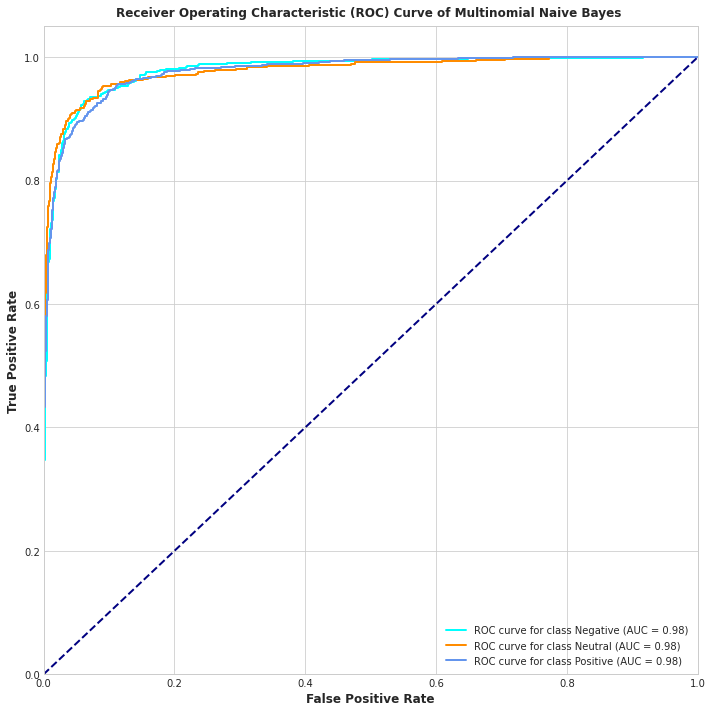

In [180]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
target_names=['Negative', 'Neutral', 'Positive']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {target_names[i]} (AUC = {auc_score[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Multinomial Naive Bayes ')
plt.legend(loc="lower right")
plt.show()

In [73]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      1298
     Neutral       0.86      0.87      0.87       490
    Positive       0.92      0.89      0.91      1239

    accuracy                           0.90      3027
   macro avg       0.89      0.90      0.89      3027
weighted avg       0.90      0.90      0.90      3027



In [74]:
from sklearn.svm import SVC

In [184]:
svm_classifier = SVC(kernel='linear',probability =True)
svm_classifier.fit(X_train_tf, y_train_le)

SVC(kernel='linear', probability=True)

In [185]:
svm_preds = svm_classifier.predict(X_test_tf)

In [186]:
svm_preds = svm_classifier.predict_proba(X_test_tf)

In [78]:
print('\tClassification Report for SVM:\n\n',classification_report(y_test_le,svm_preds, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SVM:

               precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      1298
     Neutral       0.90      0.93      0.92       490
    Positive       0.95      0.92      0.93      1239

    accuracy                           0.93      3027
   macro avg       0.93      0.93      0.93      3027
weighted avg       0.93      0.93      0.93      3027



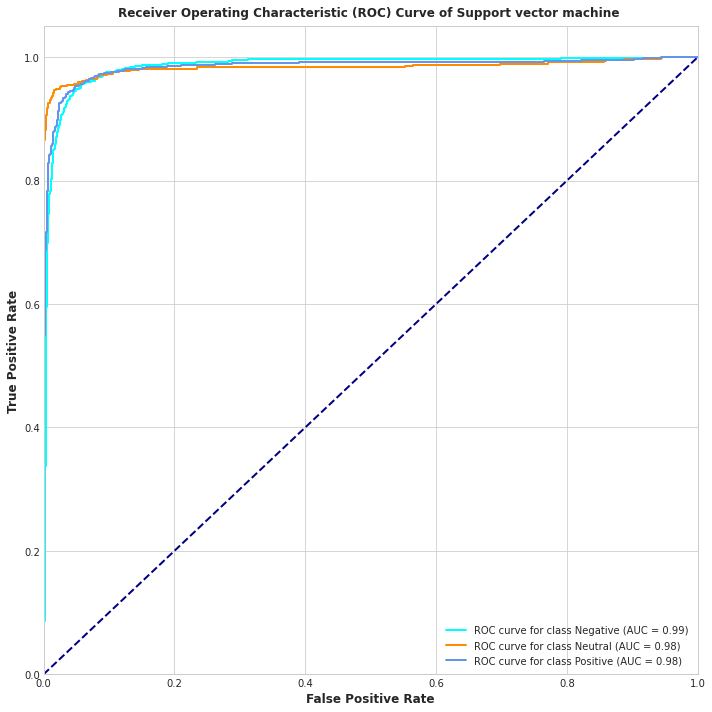

In [188]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn import datasets
from itertools import cycle
import matplotlib.pyplot as plt
modelll = OneVsRestClassifier(svm_classifier).fit(X_train_tf, y_train_le)
prob_test_vec = modelll.predict_proba(X_test_tf)
 
n_classes = 3
fpr = [0] * 3
tpr = [0] * 3
thresholds = [0] * 3
auc_score = [0] * 3
 
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i],
                                              prob_test_vec[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])
 
auc_score
# Plot ROC curves
plt.figure(figsize=(10, 10))
target_names=['Negative', 'Neutral', 'Positive']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {target_names[i]} (AUC = {auc_score[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Support vector machine ')
plt.legend(loc="lower right")
plt.show()

# BERT Sentiment Analysis

We already performed a basic analyis of the tokenized sentences, now we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [79]:
MAX_LEN=128

In [82]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [83]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [84]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [97]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [98]:
model1 = create_model(bert_model, MAX_LEN)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            2307        tf_bert_model[1][1]        

Finally we can start fine tuning the BERT transformer !

In [99]:
history_bert = model1.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=64)

Epoch 1/4
110/110 [==============================] - 101s 789ms/step - loss: 0.4885 - categorical_accuracy: 0.8340 - val_loss: 0.6924 - val_categorical_accuracy: 0.7635
Epoch 2/4
110/110 [==============================] - 87s 788ms/step - loss: 0.2222 - categorical_accuracy: 0.9307 - val_loss: 0.7235 - val_categorical_accuracy: 0.7841
Epoch 3/4
110/110 [==============================] - 88s 801ms/step - loss: 0.1171 - categorical_accuracy: 0.9668 - val_loss: 0.7550 - val_categorical_accuracy: 0.7841
Epoch 4/4
110/110 [==============================] - 88s 802ms/step - loss: 0.0815 - categorical_accuracy: 0.9771 - val_loss: 0.9047 - val_categorical_accuracy: 0.7635


In [118]:
from IPython.display import Image

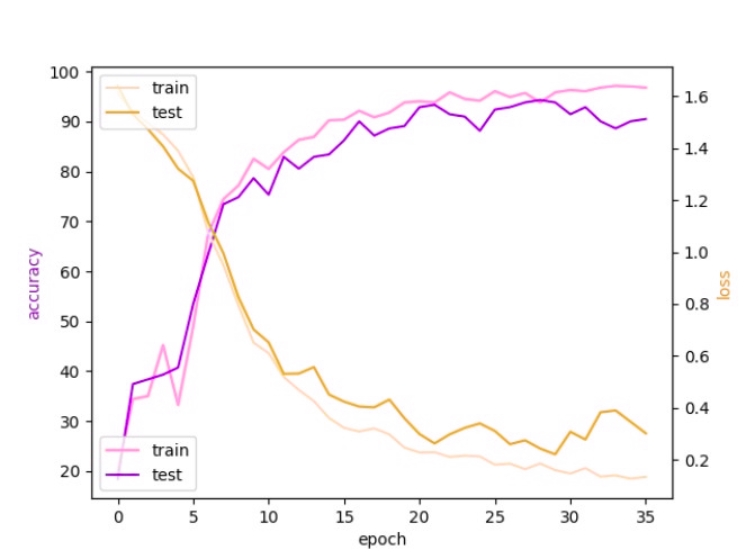

In [120]:
plt.plot(history_bert.history['categorical_accuracy'], label='train accuracy')
plt.plot(history_bert.history['val_categorical_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# Image("/kaggle/input/bertimage/Untitled design.jpg")--------------------------------REMOVEEEEEEEEEE

In [102]:
#this loads Tensorboard notebooks extension so it displays inline
%reload_ext tensorboard
...
#This will show tensorboard before training begins and it will update as training continues
%tensorboard --logdir logs
%reload_ext tensorboard

Reusing TensorBoard on port 6006 (pid 115), started 0:25:33 ago. (Use '!kill 115' to kill it.)

# BERT results

In [104]:
result_bert = model1.predict([test_input_ids,test_attention_masks])

In [107]:
y_train_le.shape

(3493,)

In [106]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

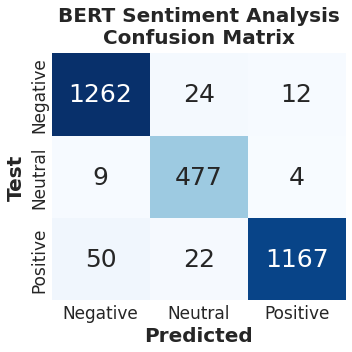

In [108]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [109]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.96      0.97      0.96      1298
     Neutral       0.91      0.97      0.94       490
    Positive       0.99      0.94      0.96      1239

   micro avg       0.96      0.96      0.96      3027
   macro avg       0.95      0.96      0.96      3027
weighted avg       0.96      0.96      0.96      3027
 samples avg       0.96      0.96      0.96      3027



In [110]:
y_pred_bert_1d = np.argmax(y_pred_bert, axis=1)

In [111]:
from scipy.stats import mode

# Combine predictions by taking the mode
combined_preds = np.array([mode([svm_preds[i],nb_pred[i], y_pred_bert_1d[i]])[0][0] for i in range(len(nb_pred))])


In [112]:
combined_preds

array([0, 2, 0, ..., 0, 0, 0])

In [113]:
# Combine predictions by simple voting
combined_preds = np.array([np.argmax(np.bincount([svm_preds[i],nb_pred[i], y_pred_bert_1d[i]])) for i in range(len(svm_preds))])

In [114]:
# Evaluate the fused predictions
accuracy = accuracy_score(y_test.argmax(1), combined_preds)
print("Accuracy:", accuracy)
print(classification_report(y_test.argmax(1), combined_preds))

Accuracy: 0.9418566237198547
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1298
           1       0.93      0.93      0.93       490
           2       0.96      0.93      0.94      1239

    accuracy                           0.94      3027
   macro avg       0.94      0.94      0.94      3027
weighted avg       0.94      0.94      0.94      3027



In [115]:

vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [197]:
rf_pred = model.predict(X_test_vec)

In [204]:
print('\tClassification Report for RF:\n\n',classification_report(y_test,rf_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RF:

               precision    recall  f1-score   support

    Negative       0.98      0.93      0.96      1298
     Neutral       0.98      0.97      0.98       490
    Positive       0.99      0.93      0.96      1239

   micro avg       0.98      0.94      0.96      3027
   macro avg       0.98      0.95      0.96      3027
weighted avg       0.98      0.94      0.96      3027
 samples avg       0.94      0.94      0.94      3027



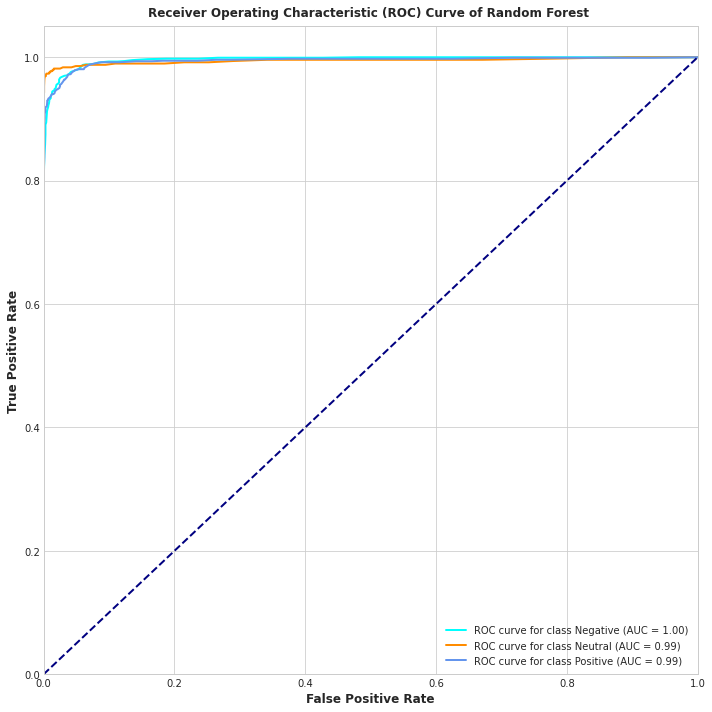

In [210]:
modelll = OneVsRestClassifier(model).fit(X_train_vec, y_train)
prob_test_vec = modelll.predict_proba(X_test_vec)
 
n_classes = 3
fpr = [0] * 3
tpr = [0] * 3
thresholds = [0] * 3
auc_score = [0] * 3
 
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i],
                                              prob_test_vec[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])
 
auc_score
# Plot ROC curves
plt.figure(figsize=(10, 10))
target_names=['Negative', 'Neutral', 'Positive']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {target_names[i]} (AUC = {auc_score[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest ')
plt.legend(loc="lower right")
plt.show()

In [116]:
feature_names = vectorizer.get_feature_names()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) 

100%|===================| 18153/18162 [11:55<00:00]        

(3027, 1134, 6)


control over stocks and gold is lostgold coming back very nicely loves wallbridge and balmoral and warns listeners about coronavirus sprott money ltd recently put in money to ocg genm mmg and many more


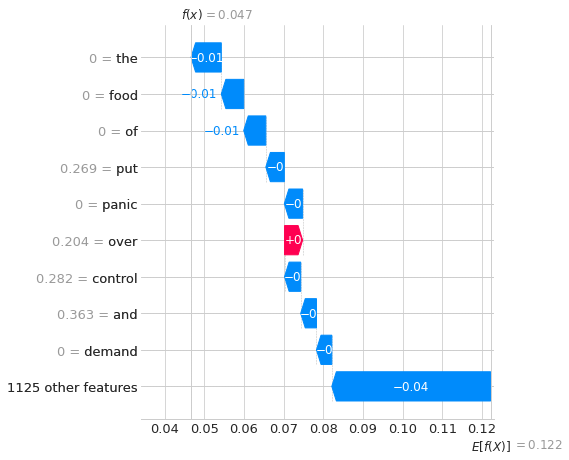

In [189]:
shap.initjs()

ind = 6
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])